# CNN in keras with pretrained word2vec weights
https://www.kaggle.com/marijakekic/cnn-in-keras-with-pretrained-word2vec-weights/notebook

In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd

In [2]:
# Helper function
def writeProgress(msg, count, total):
    sys.stdout.write(msg + "{:.2%}\r".format(count/total))
    sys.stdout.flush()
    
def newPath(path):
    if not os.path.isdir(path):
        os.mkdir(path)

def read_json(src_path):
    with open(src_path, 'r') as json_file:
        data = json.load(json_file)
    return data

def write_json(data,dst_path):
    with open(dst_path, 'w') as outfile:
        json.dump(data, outfile)

In [4]:
columns = read_json('../orderdListGenres.json')
print(len(columns), columns)

20 ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']


# load data

In [5]:
data = read_json('./input/mergeGenresMat.json')
print(len(data))

1562


In [6]:
train_data_IG=pd.read_csv('./stopword/train_IG.csv')
train_data_IG = train_data_IG.dropna()
train_data_IG = train_data_IG.reset_index(drop=True)
# train_data_IG

In [7]:
train_data_imdb=pd.read_csv('./stopword/train_imdb.csv')
train_data_imdb = train_data_imdb.dropna()
train_data_imdb = train_data_imdb.reset_index(drop=True)
train_data_imdb = train_data_imdb.rename(columns={'tconst':'username'})
# train_data_imdb

In [8]:
train_data = pd.concat([train_data_IG, train_data_imdb],ignore_index=True)
train_data

,username,convert_text,genres
0,47metersdown,catch meters uncaged spot last night nbafinals...,"['Adventure', 'Drama', 'Horror']"
1,47metersdown,know swims beneath deep meters uncaged comes t...,"['Adventure', 'Drama', 'Horror']"
2,47metersdown,stay alive meters uncaged theaters nationwide ...,"['Adventure', 'Drama', 'Horror']"
3,47metersdown,take bite summer takes bite meters uncaged dev...,"['Adventure', 'Drama', 'Horror']"
4,47metersdown,upside irl sharkbait,"['Adventure', 'Drama', 'Horror']"
5,47metersdown,taking bite summer one month meters uncaged hi...,"['Adventure', 'Drama', 'Horror']"
6,47metersdown,summer vacation leveled meters uncaged theater...,"['Adventure', 'Drama', 'Horror']"
7,47metersdown,could possibly go wrong meters uncaged hits th...,"['Adventure', 'Drama', 'Horror']"
8,47metersdown,ready seconds meters uncaged devours theaters ...,"['Adventure', 'Drama', 'Horror']"
9,47metersdown,important balanced diet meters uncaged takes t...,"['Adventure', 'Drama', 'Horror']"


In [9]:
test_data=pd.read_csv('./stopword/test.csv')
test_data

,username,convert_text
0,47metersdown,four teen girls diving ruined underwater city ...
1,adogsjourneymovie,dog finds meaning existence lives humans meets
2,aftermathmovie,post world war ii british colonel wife assigne...
3,aftermovie,young woman falls guy dark secret two embark r...
4,alitamovie,deactivated cyborg revived remember anything p...
5,angelhasfallen,secret service agent mike banning framed attem...
6,angrybirdsmovie,flightless birds scheming green pigs take feud...
7,annabellemovie,babysitting daughter ed lorraine warren teenag...
8,annamovie,beneath anna poliatova striking beauty lies se...
9,apollo11movie,look apollo mission land moon led commander ne...


In [10]:
print(train_data.shape,test_data.shape)
print(train_data.isnull().sum())
print(test_data.isnull().sum())

(11740, 3) (97, 2)
username        0
convert_text    0
genres          0
dtype: int64
username        0
convert_text    0
dtype: int64


In [11]:
ids = train_data['username'].tolist()
texts = train_data['convert_text'].tolist()
print(len(ids), len(texts))

11740 11740


In [12]:
labels = [data[id] for id in ids]
len(labels)

11740

In [13]:
val_data=train_data.sample(frac=0.2,random_state=42)
train_data= train_data.drop(val_data.index)
print(train_data.shape, val_data.shape)

(9392, 3) (2348, 3)


# Tokenize

In [14]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

C:\Users\TONYLAB\Anaconda3\envs\tensorflow-gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\TONYLAB\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\TONYLAB\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Us

In [15]:
texts = train_data.convert_text

In [16]:
NUM_WORDS=30000
tokenizer = Tokenizer(num_words=NUM_WORDS,filters='—!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                      lower=True)

tokenizer.fit_on_texts(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 18046 unique tokens.


In [17]:
# sorted(word_index.items(), key=lambda d: d[1])

In [18]:
sequences_train = tokenizer.texts_to_sequences(texts)
sequences_valid = tokenizer.texts_to_sequences(val_data.convert_text)

X_train = pad_sequences(sequences_train)
X_val = pad_sequences(sequences_valid,maxlen=X_train.shape[1])
labels = np.asarray(labels)

y_train = np.asarray(labels[train_data.index.values])
y_val = np.asarray(labels[val_data.index.values])

print('Shape of X train and X validation tensor:', X_train.shape,X_val.shape)
print('Shape of label train and validation tensor:', y_train.shape,y_val.shape)

Shape of X train and X validation tensor: (9392, 330) (2348, 330)
Shape of label train and validation tensor: (9392, 20) (2348, 20)


# Embedding

In [19]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors

outOfDict = []

word_vectors = KeyedVectors.load_word2vec_format('./model/GoogleNews-vectors-negative300.bin', binary=True)

EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,NUM_WORDS)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)
        outOfDict.append(word)

In [20]:
write_json(outOfDict, 'unstemmed_outOfDict.json')

In [21]:
del(word_vectors)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

## 儲存路徑

In [112]:
SAVE_NAME = 'merge_stride6'
HISTORY_SAVE = './history/' + SAVE_NAME + '.csv'
WEIGHTS_SAVE = './weight/' + SAVE_NAME + '.h5'

## Model Structure

In [113]:
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import Model
from keras import regularizers

sequence_length = X_train.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.5
stride = 6

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_2 = Conv2D(num_filters, (filter_sizes[2], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(stride,1))(conv_0)
maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(stride,1))(conv_1)
maxpool_2 = MaxPooling2D((sequence_length - filter_sizes[2] + 1, 1), strides=(stride,1))(conv_2)

merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
flatten = Flatten()(merged_tensor)
reshape = Reshape((3*num_filters,))(flatten)
dropout = Dropout(drop)(flatten)
output = Dense(units=20, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01))(dropout)

# this creates a model that includes
model = Model(inputs, output)

In [114]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 330)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 330, 300)     5414100     input_6[0][0]                    
__________________________________________________________________________________________________
reshape_11 (Reshape)            (None, 330, 300, 1)  0           embedding_1[5][0]                
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 328, 1, 100)  90100       reshape_11[0][0]                 
__________________________________________________________________________________________________
conv2d_17 

In [115]:
adam = Adam(lr=1e-3)

model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['acc'])
callbacks = [EarlyStopping(monitor='val_loss')]
history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1, validation_data=(X_val, y_val), callbacks=callbacks)  # starts training

Train on 9392 samples, validate on 2348 samples
Epoch 1/100
9392/9392 [==============================] - 11s 1ms/step - loss: 0.2666 - acc: 0.9678 - val_loss: 0.1632 - val_acc: 0.9688
Epoch 2/100
9392/9392 [==============================] - 11s 1ms/step - loss: 0.1458 - acc: 0.9741 - val_loss: 0.1549 - val_acc: 0.9701
Epoch 3/100
9392/9392 [==============================] - 11s 1ms/step - loss: 0.1427 - acc: 0.9745 - val_loss: 0.1560 - val_acc: 0.9698


In [116]:
# save model weights
model.save(WEIGHTS_SAVE)

In [117]:
# save history
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

his_df = pd.DataFrame(data = {
    'Epoch' : epochs,
    'Loss' : loss,
    'Acc' : acc,
    'Val_loss' : val_loss,
    'Val_acc' : val_acc
})
his_df = his_df[['Epoch', 'Loss', 'Acc', 'Val_loss', 'Val_acc']]
his_df.to_csv(HISTORY_SAVE, index = False)

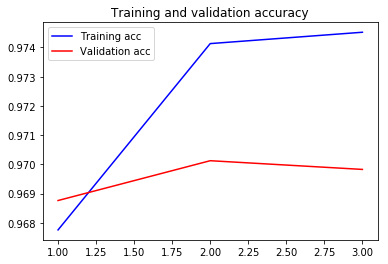

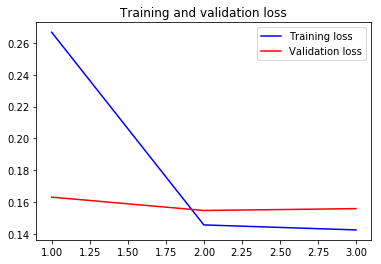

In [118]:
# 繪製結果
import matplotlib.pyplot as plt

# plt.figure()

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

# plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Testing

In [119]:
sequences_test=tokenizer.texts_to_sequences(test_data.convert_text)
X_test = pad_sequences(sequences_test,maxlen=X_train.shape[1])
pred = model.predict(X_test)

In [120]:
pred.shape

(97, 20)

In [121]:
predictions = pred #pred_bool.astype(int)

results=pd.DataFrame(predictions, columns=columns)
results["username"] = test_data.username
ordered_cols = ["username"] + columns
results = results[ordered_cols] #To get the same column order
results.to_csv("./output/"+ SAVE_NAME + "_result.csv",index=False)

## Label top n dynamic

In [122]:
true_df = pd.read_csv('./input/true_df.csv')
true_df

,username,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,History,Horror,Music,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,47metersdown,0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
1,adogsjourneymovie,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,aftermathmovie,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
3,aftermovie,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,alitamovie,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,angelhasfallen,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,angrybirdsmovie,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,annabellemovie,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0
8,annamovie,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9,apollo11movie,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


In [123]:
results = pd.read_csv("./output/"+ SAVE_NAME + "_result.csv")
results

,username,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,History,Horror,Music,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,47metersdown,0.058234,0.161298,0.065857,0.023527,0.079614,0.012397,0.021470,0.318811,0.042827,...,0.031427,0.209332,0.015944,1.037981e-01,1.517850e-02,0.024054,0.028792,5.966360e-02,0.020962,0.012471
1,adogsjourneymovie,0.077369,0.160498,0.078713,0.230617,0.337393,0.064525,0.071940,0.798182,0.085742,...,0.132293,0.036848,0.118723,5.921547e-02,1.825755e-01,0.031682,0.080869,3.753663e-02,0.072205,0.035153
2,aftermathmovie,0.024737,0.018634,0.014778,0.061507,0.111508,0.046513,0.033217,0.691502,0.040187,...,0.066709,0.128227,0.039546,1.827862e-01,7.940035e-02,0.022131,0.041912,1.654355e-01,0.035978,0.017606
3,aftermovie,0.457640,0.026231,0.001260,0.004528,0.019389,0.067005,0.007161,0.147848,0.004417,...,0.011105,0.034925,0.002502,2.332068e-02,4.275392e-03,0.034547,0.003232,4.474348e-01,0.007271,0.005299
4,alitamovie,0.997311,0.991464,0.000492,0.000085,0.000016,0.000068,0.000074,0.007515,0.000208,...,0.000087,0.000060,0.000005,6.179558e-07,1.664704e-06,0.793130,0.000017,9.002270e-04,0.000248,0.000072
5,angelhasfallen,0.263867,0.324017,0.060734,0.055528,0.187379,0.041660,0.042202,0.321673,0.052706,...,0.057684,0.053222,0.032211,3.053386e-02,4.866788e-02,0.046969,0.025010,4.021972e-02,0.032711,0.022225
6,angrybirdsmovie,0.084399,0.969516,0.549179,0.003541,0.957349,0.000321,0.000894,0.104755,0.005291,...,0.000648,0.002380,0.001995,5.936572e-04,3.078484e-03,0.000763,0.012852,1.658499e-05,0.002251,0.001454
7,annabellemovie,0.013108,0.004065,0.000718,0.004787,0.000827,0.001644,0.003599,0.647613,0.002914,...,0.010930,0.026965,0.001114,1.468408e-02,1.700687e-03,0.115826,0.003618,3.081199e-01,0.004784,0.001131
8,annamovie,0.548898,0.033927,0.002042,0.004374,0.037982,0.087937,0.011139,0.082698,0.004982,...,0.014715,0.054863,0.003095,2.748280e-02,5.210011e-03,0.038081,0.003553,4.925750e-01,0.007747,0.007083
9,apollo11movie,0.251312,0.123063,0.026666,0.080172,0.031858,0.037319,0.154453,0.273639,0.065627,...,0.229438,0.055160,0.036328,1.874672e-02,7.283646e-02,0.321649,0.018242,2.492544e-01,0.044783,0.024414


In [124]:
labels = read_json('../genresDic.json')

In [125]:
def countAcc(predList, trueList):
    fraction = 0
    denominator = len(trueList)
    for g in predList:
        if g in trueList:
            fraction += 1 
    return fraction / denominator

In [126]:
li = []
for i, row in true_df.iterrows():
    username = row['username']
    if username == results.loc[i,:]['username']: # username equals
        print(i, username)
        truth = labels[username]
        numTrue = sum(row[1:])
        print('count:', numTrue)
        
        s = results.loc[i,:][1:]
        top_n = s.sort_values(ascending=False)[:numTrue]
        inList = list(top_n.index)
        
        onehot = []
        for g in columns:
            onehot.append(int(g in inList))
            
        acc = countAcc(inList, truth)
        print(acc, inList, truth)
        
        appList = [username, acc, truth, inList] + onehot
        li.append(appList)
        

0 47metersdown
count: 3
1.0 ['Drama', 'Horror', 'Adventure'] ['Adventure', 'Drama', 'Horror']
1 adogsjourneymovie
count: 3
0.6666666666666666 ['Drama', 'Comedy', 'Biography'] ['Adventure', 'Comedy', 'Drama']
2 aftermathmovie
count: 3
0.3333333333333333 ['Drama', 'Mystery', 'Thriller'] ['Drama', 'Romance', 'War']
3 aftermovie
count: 2
0.0 ['Action', 'Thriller'] ['Drama', 'Romance']
4 alitamovie
count: 3
1.0 ['Action', 'Adventure', 'Sci-Fi'] ['Action', 'Adventure', 'Sci-Fi']
5 angelhasfallen
count: 2
0.0 ['Adventure', 'Drama'] ['Action', 'Thriller']
6 angrybirdsmovie
count: 3
1.0 ['Adventure', 'Comedy', 'Animation'] ['Adventure', 'Animation', 'Comedy']
7 annabellemovie
count: 3
0.3333333333333333 ['Drama', 'Thriller', 'Sci-Fi'] ['Horror', 'Mystery', 'Thriller']
8 annamovie
count: 2
1.0 ['Action', 'Thriller'] ['Action', 'Thriller']
9 apollo11movie
count: 2
0.0 ['Sci-Fi', 'Drama'] ['Documentary', 'History']
10 arcticmovie
count: 2
1.0 ['Drama', 'Adventure'] ['Adventure', 'Drama']
11 artofr

In [127]:
acc_df = pd.DataFrame(li, columns = ['username', 'acc', 'truth', 'top_n'] + columns)
acc_df

,username,acc,truth,top_n,Action,Adventure,Animation,Biography,Comedy,Crime,...,History,Horror,Music,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,47metersdown,1.000000,"[Adventure, Drama, Horror]","[Drama, Horror, Adventure]",0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,adogsjourneymovie,0.666667,"[Adventure, Comedy, Drama]","[Drama, Comedy, Biography]",0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,aftermathmovie,0.333333,"[Drama, Romance, War]","[Drama, Mystery, Thriller]",0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,aftermovie,0.000000,"[Drama, Romance]","[Action, Thriller]",1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,alitamovie,1.000000,"[Action, Adventure, Sci-Fi]","[Action, Adventure, Sci-Fi]",1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,angelhasfallen,0.000000,"[Action, Thriller]","[Adventure, Drama]",0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,angrybirdsmovie,1.000000,"[Adventure, Animation, Comedy]","[Adventure, Comedy, Animation]",0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,annabellemovie,0.333333,"[Horror, Mystery, Thriller]","[Drama, Thriller, Sci-Fi]",0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
8,annamovie,1.000000,"[Action, Thriller]","[Action, Thriller]",1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9,apollo11movie,0.000000,"[Documentary, History]","[Sci-Fi, Drama]",0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [128]:
acc_df.to_csv("./output/"+ SAVE_NAME + "_bi.csv", index = 0)

In [129]:
acc_df['acc'].mean()

0.6735395189003436

# Feature Extraction
## 測試reload model準確度

In [130]:
SAVE_NAME = 'test'

In [131]:
WEIGHTS_LOAD = './weight/merge_stride4.h5'

from keras.models import load_model

model = load_model(WEIGHTS_LOAD)

In [132]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 330)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 330, 300)     5414100     input_4[0][0]                    
__________________________________________________________________________________________________
reshape_7 (Reshape)             (None, 330, 300, 1)  0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 328, 1, 100)  90100       reshape_7[0][0]                  
__________________________________________________________________________________________________
conv2d_11 

In [133]:
sequences_test=tokenizer.texts_to_sequences(test_data.convert_text)
X_test = pad_sequences(sequences_test,maxlen=X_train.shape[1])
pred = model.predict(X_test)
pred.shape

(97, 20)

In [134]:
predictions = pred

results=pd.DataFrame(predictions, columns=columns)
results["username"] = test_data.username
ordered_cols = ["username"] + columns
results = results[ordered_cols] #To get the same column order
results.to_csv("./output/"+ SAVE_NAME + "_result.csv",index=False)

In [135]:
labels = read_json('../genresDic.json')

In [136]:
li = []
for i, row in true_df.iterrows():
    username = row['username']
    if username == results.loc[i,:]['username']: # username equals
        print(i, username)
        truth = labels[username]
        numTrue = sum(row[1:])
        print('count:', numTrue)
        
        s = results.loc[i,:][1:]
        top_n = s.sort_values(ascending=False)[:numTrue]
        inList = list(top_n.index)
        
        onehot = []
        for g in columns:
            onehot.append(int(g in inList))
            
        acc = countAcc(inList, truth)
        print(acc, inList, truth)
        
        appList = [username, acc, truth, inList] + onehot
        li.append(appList)

0 47metersdown
count: 3
1.0 ['Horror', 'Adventure', 'Drama'] ['Adventure', 'Drama', 'Horror']
1 adogsjourneymovie
count: 3
1.0 ['Drama', 'Comedy', 'Adventure'] ['Adventure', 'Comedy', 'Drama']
2 aftermathmovie
count: 3
0.3333333333333333 ['Drama', 'Mystery', 'Horror'] ['Drama', 'Romance', 'War']
3 aftermovie
count: 2
0.0 ['Action', 'Thriller'] ['Drama', 'Romance']
4 alitamovie
count: 3
1.0 ['Action', 'Sci-Fi', 'Adventure'] ['Action', 'Adventure', 'Sci-Fi']
5 angelhasfallen
count: 2
0.5 ['Adventure', 'Action'] ['Action', 'Thriller']
6 angrybirdsmovie
count: 3
1.0 ['Adventure', 'Comedy', 'Animation'] ['Adventure', 'Animation', 'Comedy']
7 annabellemovie
count: 3
0.3333333333333333 ['Drama', 'Thriller', 'Sci-Fi'] ['Horror', 'Mystery', 'Thriller']
8 annamovie
count: 2
1.0 ['Action', 'Thriller'] ['Action', 'Thriller']
9 apollo11movie
count: 2
0.0 ['Sci-Fi', 'Action'] ['Documentary', 'History']
10 arcticmovie
count: 2
1.0 ['Drama', 'Adventure'] ['Adventure', 'Drama']
11 artofracingmovie
coun

In [137]:
acc_df = pd.DataFrame(li, columns = ['username', 'acc', 'truth', 'top_n'] + columns)
acc_df['acc'].mean()

0.7027491408934707

## 萃取97部電影imdb的feature

In [140]:
X_test.shape

(97, 330)

In [143]:
extract_layer = Model(inputs=model.input,
                      outputs=model.get_layer('flatten_4').output)
#以这个model的预测值作为输出
extract_output = extract_layer.predict(X_test)
print(extract_output.shape)

(97, 300)


In [155]:
idx = test_data.username.tolist()
print(len(idx), idx)

97 ['47metersdown', 'adogsjourneymovie', 'aftermathmovie', 'aftermovie', 'alitamovie', 'angelhasfallen', 'angrybirdsmovie', 'annabellemovie', 'annamovie', 'apollo11movie', 'arcticmovie', 'artofracingmovie', 'avengers', 'beachbummovie', 'bernadettefilm', 'blindedbythelightmovie', 'booksmart', 'breakthroughmovie', 'brianbanksmovie', 'brightburnmovie', 'brittanyrunsmov', 'captainmarvelofficial', 'captivestatemovie', 'childsplaymovie', 'clarathefilm', 'coldpursuitmovie', 'detectivepikachumovie', 'disneyaladdin', 'doramovie', 'dumbo', 'escaperoom', 'everybodyknowsmovie', 'fastandfuriousmovie', 'fightingwmyfam', 'fivefeetapartfilm', 'glassmovie', 'gloriabellmovie', 'godzillamovie', 'goodboysmovie', 'gretafilm', 'happydeathdaymovie', 'hellboymovie', 'hersmellmovie', 'highlifemovie', 'hotelmumbaifilm', 'httydragon', 'hustlemovie', 'isntitromantic', 'johnwickmovie', 'lalloronamovie', 'lastblackmansf', 'latenightmovie', 'lionking', 'littlethemovie', 'littlewoodsfilm', 'longshotmovie', 'mamovie20

In [156]:
res=pd.DataFrame(extract_output, index = idx)
res

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
47metersdown,0.374739,0.270051,0.609296,1.569829,1.344152,0.574243,0.749028,1.403713,1.386527,1.607003,...,1.267052,1.663003,0.495637,0.488453,1.065453,0.332843,0.726915,0.437903,0.986801,1.048887
adogsjourneymovie,0.374376,0.067667,0.645954,0.549451,0.206821,0.676822,0.550376,0.711265,0.147931,1.607003,...,0.130237,0.797118,0.148777,0.827414,0.311918,0.149246,1.262665,0.224989,0.124400,0.771652
aftermathmovie,0.410768,0.157005,0.646724,0.334156,0.277689,0.631145,0.327160,0.412415,1.363493,1.607003,...,1.379211,0.727522,0.359066,1.111048,0.952102,0.408791,1.344656,0.452482,0.911157,0.312672
aftermovie,1.668443,0.567410,0.460005,1.072697,0.775445,0.493064,0.392852,1.162051,1.996669,1.607003,...,1.994265,1.159563,0.492684,0.603645,1.408402,0.966915,0.861988,0.427120,1.156701,0.644780
alitamovie,4.932076,1.962781,1.608741,6.178146,5.476745,1.580918,0.615368,5.199157,1.110912,1.607003,...,1.144033,5.215600,2.247739,2.182832,1.835538,1.434132,2.434352,0.676959,0.739323,0.830026
angelhasfallen,0.890976,0.183025,0.293354,1.432116,1.032722,0.340422,0.383614,1.456308,0.471986,1.607003,...,0.399420,1.500822,0.399060,0.447397,0.956196,0.292946,0.559920,0.370190,0.437232,0.520342
angrybirdsmovie,1.239590,0.253446,0.467602,4.017891,3.568449,0.494896,3.029965,4.068507,0.288963,1.607003,...,0.359133,5.437123,0.997650,0.589184,0.967953,0.578517,0.865434,2.240531,0.472459,3.881594
annabellemovie,1.045750,0.529480,1.349088,1.746881,1.457422,1.885999,0.248677,1.497988,2.551872,1.607003,...,2.437018,1.793787,0.675897,1.953070,1.724746,0.642769,1.917683,0.768738,1.922758,0.451272
annamovie,1.667688,0.358395,0.309363,0.970258,0.711452,0.296906,0.370924,1.126944,1.747096,1.607003,...,1.702756,1.039828,0.322417,0.113926,1.238351,0.763497,0.336850,0.446046,0.762263,0.285188
apollo11movie,0.713623,0.375222,0.201007,0.490758,0.453246,0.174818,0.090815,0.570558,0.436193,1.607003,...,0.231844,0.700142,0.793467,0.205722,0.938739,0.394009,0.449556,0.017436,0.106767,0.040854


In [158]:
res.to_csv("./output/TextFeatureVec.csv", header=False)